## Demonstrate full circle wide field imaging

This include prediction of components, inversion, point source fitting. We will compare the output images with the input models, looking for closeness in flux and position.

In [1]:
%matplotlib inline

import os
import sys
import copy
import multiprocessing

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.convolution import Gaussian2DKernel, convolve

from astropy.coordinates import SkyCoord, CartesianRepresentation
from astropy.time import Time
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from arl.visibility.operations import create_visibility, sum_visibility
from arl.visibility.iterators import vis_timeslice_iter, vis_wslice_iter
from arl.util.testing_support import create_named_configuration

from matplotlib import pyplot as plt

from arl.skymodel.operations import create_skycomponent, find_skycomponents, \
    find_nearest_component, insert_skycomponent
from arl.image.operations import show_image, export_image_to_fits, create_empty_image_like, qa_image
from arl.image.iterators import raster_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import *

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the SKA1-LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre, npol=1)

create_visibility: 95865 rows, 0.116 GB


Fill in the visibility with exact calculation of a number of point sources

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 32
Component at (239.000000, 15.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 4.74378292, -51.0209895)>
insert_skycomponent: Inserting point flux [[ 23.]] at [240, 16] (0 rel) 
Component at (207.000000, 15.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 7.66144755, -51.22149637)>
insert_skycomponent: Inserting point flux [[ 25.]] at [208, 16] (0 rel) 
Component at (175.000000, 15.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 10.5917361, -51.35530369)>
insert_sk

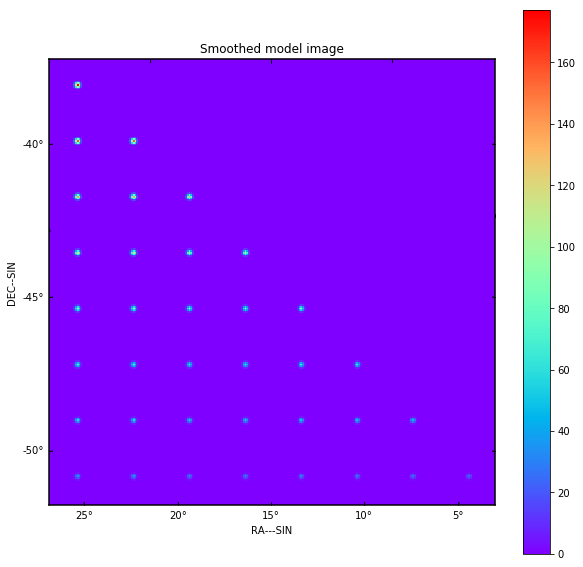

In [4]:
vt.data['vis'] *= 0.0
npixel=256

model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, npol=1, nchan=1)
centre = model.wcs.wcs.crpix-1
spacing_pixels = npixel // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = model.wcs.wcs.cdelt * spacing_pixels
locations = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in locations:
    for ix in locations:
        if ix >= iy:
            p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[0]))), \
                int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[1])))
            sc = pixel_to_skycoord(p[0], p[1], model.wcs)
            log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
            flux = numpy.array([[100.0 + 2.0 * ix + iy * 20.0]])
            comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc)
            original_comps.append(comp)
            predict_skycomponent_visibility(vt, comp)
            insert_skycomponent(model, comp)
        
cmodel = create_empty_image_like(model) 
cmodel.data[0,0,:,:] = convolve(model.data[0,0,:,:], Gaussian2DKernel(1.0), normalize_kernel=True)
cmodel.data *= numpy.max(model.data) / numpy.max(cmodel.data)
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

Check that the skycoordinate and image coordinate system are consistent by finding the point sources.

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


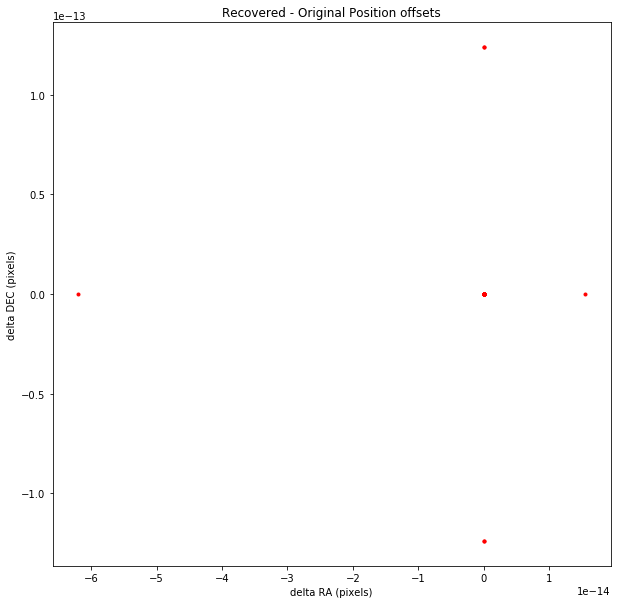

In [5]:
comps = find_skycomponents(cmodel, fwhm=1.0, threshold=10.0, npixels=5)
plt.clf()
for i in range(len(comps)):
    ocomp = find_nearest_component(comps[i].direction, original_comps)
    plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/cmodel.wcs.wcs.cdelt[0], 
             (comps[i].direction.dec.value - ocomp.direction.dec.value)/cmodel.wcs.wcs.cdelt[1], 
             '.', color='r')  

plt.xlabel('delta RA (pixels)')
plt.ylabel('delta DEC (pixels)')
plt.title("Recovered - Original Position offsets")
plt.show()

Predict the visibility using the different approaches.

create_visibility: 95865 rows, 0.116 GB
predict_2d: predict using 2d transform


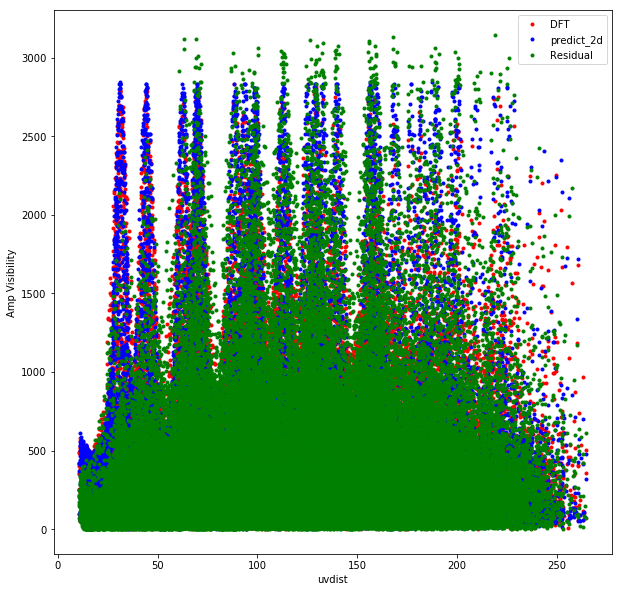

create_visibility: 95865 rows, 0.116 GB
predict_timeslice: predicting using time slices
predict_with_vis_iterator: Processing chunks serially
predict_timeslice: predicting using time slices
predict_timeslice: Fit to 13695 rows reduces rms w from 59.6 to 0.0 m
Reprojecting model from SIN projection to oblique SIN projection with params 0.826409, -0.168719
predict_timeslice: Using griddata to convert projection
predict_2d: predict using 2d transform
predict_timeslice: predicting using time slices
predict_timeslice: Fit to 13695 rows reduces rms w from 46.1 to 0.0 m
Reprojecting model from SIN projection to oblique SIN projection with params 0.516524, -0.265219
predict_timeslice: Using griddata to convert projection
predict_2d: predict using 2d transform
predict_timeslice: predicting using time slices
predict_timeslice: Fit to 13695 rows reduces rms w from 33.7 to 0.0 m
Reprojecting model from SIN projection to oblique SIN projection with params 0.249188, -0.315193
predict_timeslice: Usin

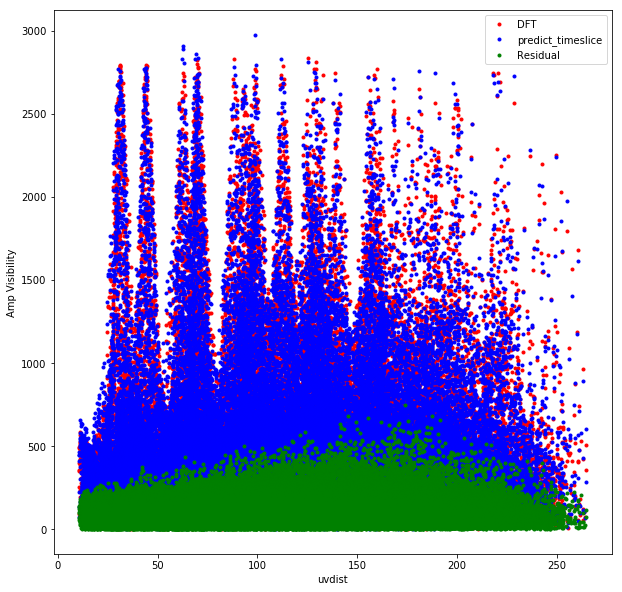

create_visibility: 95865 rows, 0.116 GB
predict_wslice: predicting using w slices
predict_with_vis_iterator: Processing chunks serially
predict_wslice: predicting using w slices
create_w_term_image: For w = -157.7, field of view = 0.256000, Fresnel number = 2.58
predict_2d: predict using 2d transform
predict_wslice: predicting using w slices
create_w_term_image: For w = -149.3, field of view = 0.256000, Fresnel number = 2.45
predict_2d: predict using 2d transform
predict_wslice: predicting using w slices
create_w_term_image: For w = -139.7, field of view = 0.256000, Fresnel number = 2.29
predict_2d: predict using 2d transform
predict_wslice: predicting using w slices
create_w_term_image: For w = -129.4, field of view = 0.256000, Fresnel number = 2.12
predict_2d: predict using 2d transform
predict_wslice: predicting using w slices
create_w_term_image: For w = -119.1, field of view = 0.256000, Fresnel number = 1.95
predict_2d: predict using 2d transform
predict_wslice: predicting using w

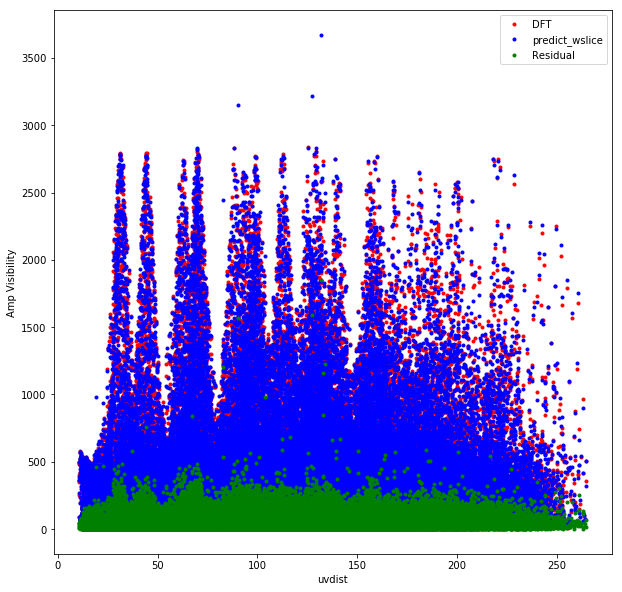

create_visibility: 95865 rows, 0.116 GB
predict_facets: Predicting by image facets
predict_with_image_iterator: Predicting by image partitions
raster: predicting using 8 x 8 image partitions
raster: spacing of raster (32, 32)
raster: partition (0, 0) of (8, 8)
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
raster: partition (1, 0) of (8, 8)
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 22.33855245, -51.22149637)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
raster: partition (2, 0) of (8, 8)
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 19.4082639, -51.35530369)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
raster: partition (3, 0) o

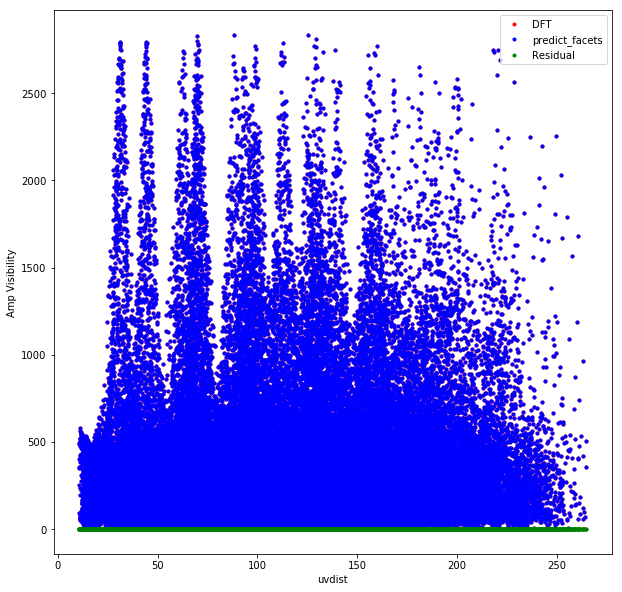

create_visibility: 95865 rows, 0.116 GB
predict_wprojection: predict using wprojection
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 65.536000
get_kernel_list: Recommended wstep = 0.242851
get_kernel_list: Using w projection with wstep = 10.000000
get_kernel_list: Maximum w kernel full width = 32 pixels
w_kernel_list: Maximum w = 169.6 , step is 10.0 wavelengths


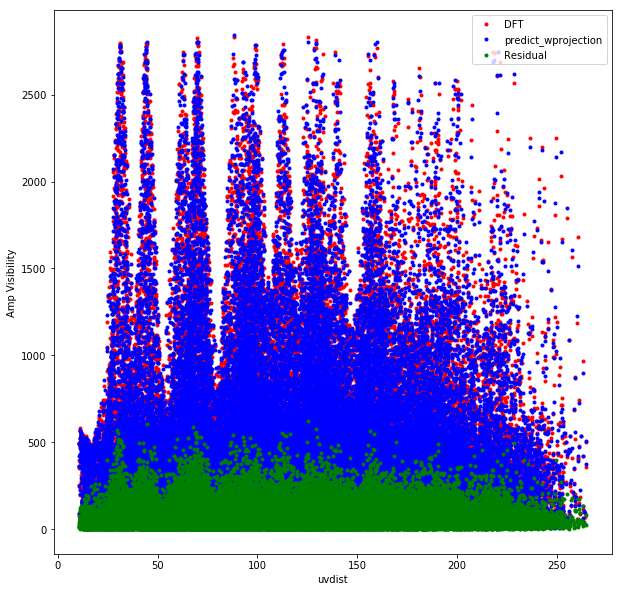

In [6]:
processors = [predict_2d, predict_timeslice, predict_wslice, predict_facets, predict_wprojection]

for processor in processors:
    
    uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
    plt.clf()
    plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='r', label="DFT")   
    vtpredict = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre, npol=1)

    vtpredict = processor(vtpredict, model, nprocessor=1, timeslice=1.0,
                          padding=2, oversampling=4, image_partitions=8, wstep=10.0, wslice=10.0)
        
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]), '.', color='b', label=processor.__name__)
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]-vt.data['vis'][:]), '.', color='g', label="Residual")
    plt.xlabel('uvdist')
    plt.ylabel('Amp Visibility')
    plt.legend()
    plt.show()

Make the image using the different approaches. We will evaluate the results using a number of plots:

- The recovered flux versus distance from phase centre. We show two forms: the result fitted and the result from a DFT at the expected position. The ideal result would blue and red dots overlaid.
- The offset in RA versus the offset in DEC. The ideal result is a cluster around 0 pixels.
- The fitted flux versus the DFT flux. The ideal result is a straightline fitted: flux = DFT flux

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d transform


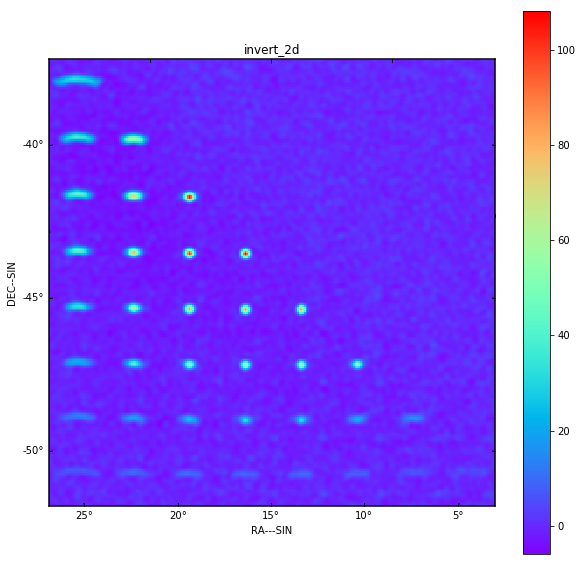

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_2d
	Data:
		shape: (1, 1, 256, 256)
		max: 108.265070911
		min: -6.02493250406
		rms: 4.92597849297
		sum: 3401.94764543
		medianabs: 1.15344252035
		median: -0.587593205395

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 28 segments


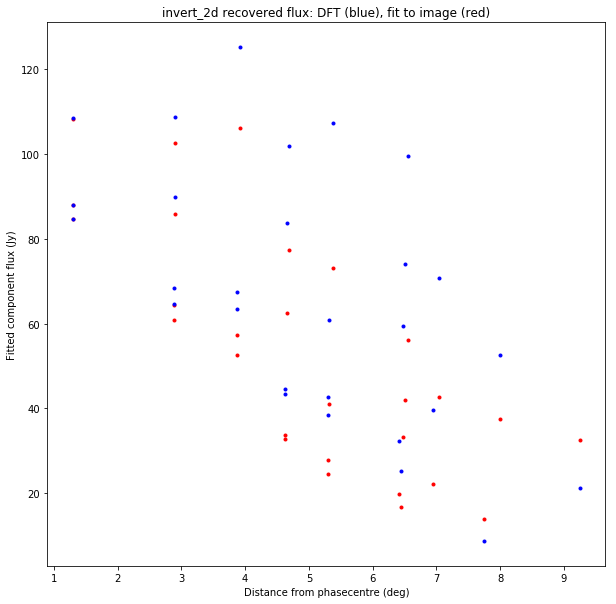

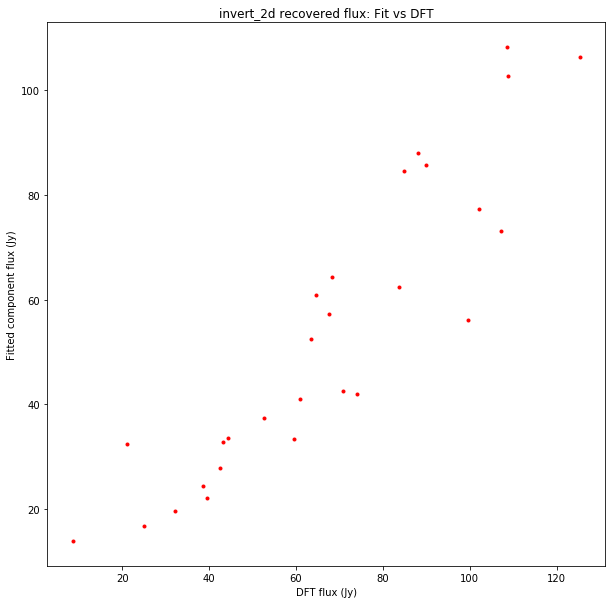

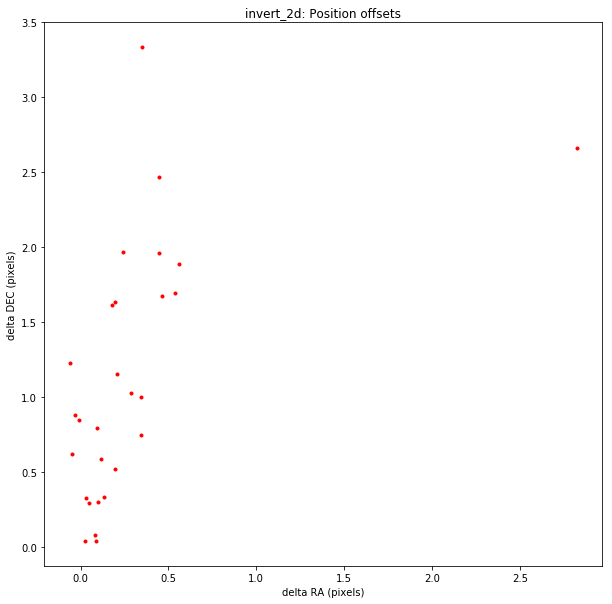

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_timeslice: inverting using time slices
vis_timeslice_iter: Found 7 unique times
vis_timeslice_auto: Guessing time interval to be 3600.00 s
predict_timeslice: Fit to 13695 rows reduces rms w from 59.6 to 0.0 m
invert_2d: inverting using 2d transform
Time=-10800.000000, p=0.826, q=-0.169
predict_timeslice: Fit to 13695 rows reduces rms w from 46.1 to 0.0 m
invert_2d: inverting using 2d transform
Time=-7200.000000, p=0.517, q=-0.265
predict_timeslice: Fit to 13695 rows reduces rms w from 33.7 to 0.0 m
inver

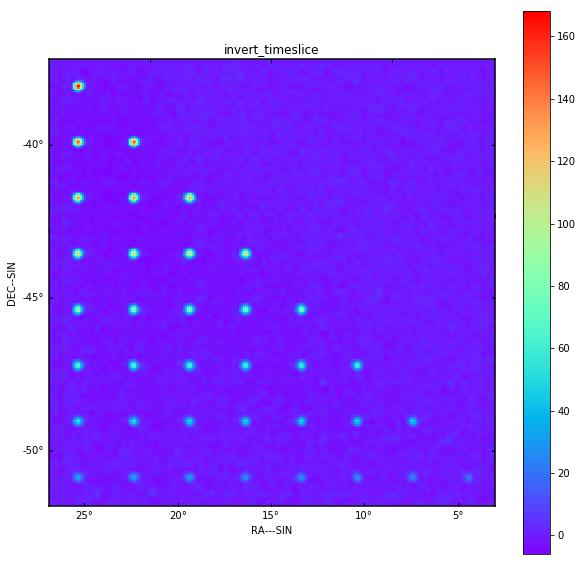

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_timeslice
	Data:
		shape: (1, 1, 256, 256)
		max: 168.27561117
		min: -6.10375531935
		rms: 6.52144137058
		sum: 4240.21412754
		medianabs: 1.10019920155
		median: -0.628039908102

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


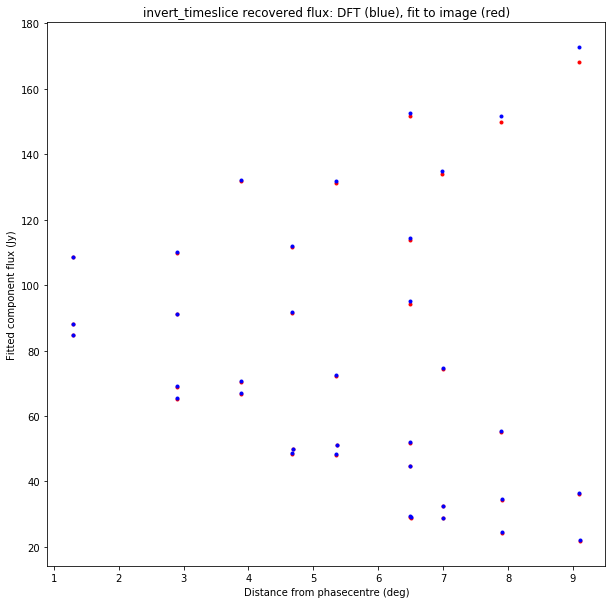

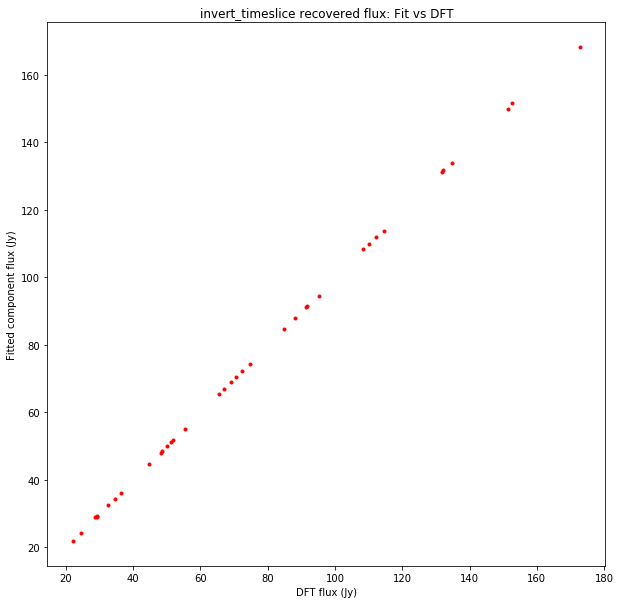

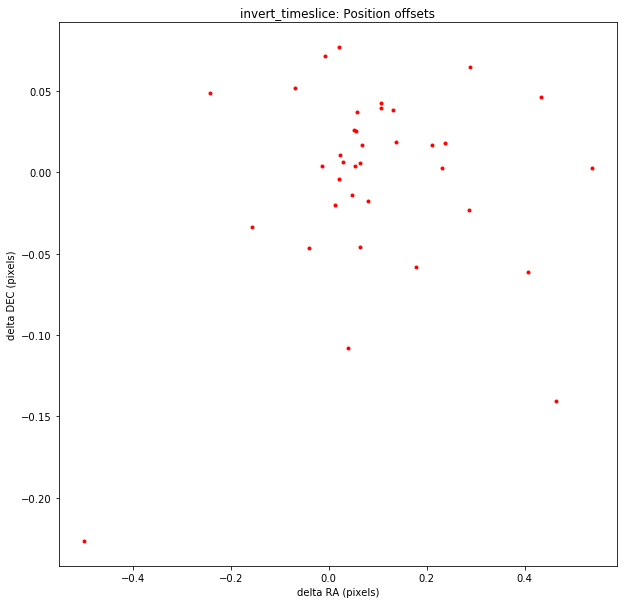

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_wslice: inverting using w slices
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = -157.7, field of view = 0.256000, Fresnel number = 2.58
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = -149.3, field of view = 0.256000, Fresnel number = 2.45
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = -139.7, field of view = 0.256000, Fresnel number = 2.29
invert_2d_base: retaining imaginary part of dirty ima

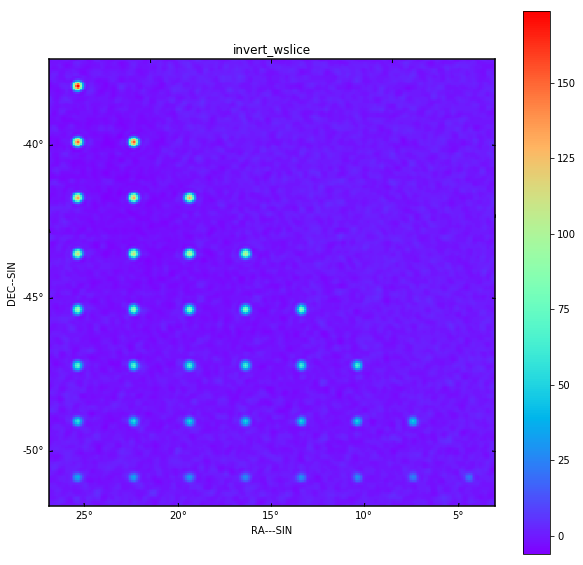

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_wslice
	Data:
		shape: (1, 1, 256, 256)
		max: 173.923775334
		min: -6.15017410659
		rms: 6.52623838715
		sum: 3176.5818624
		medianabs: 1.13417138032
		median: -0.658465914564

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


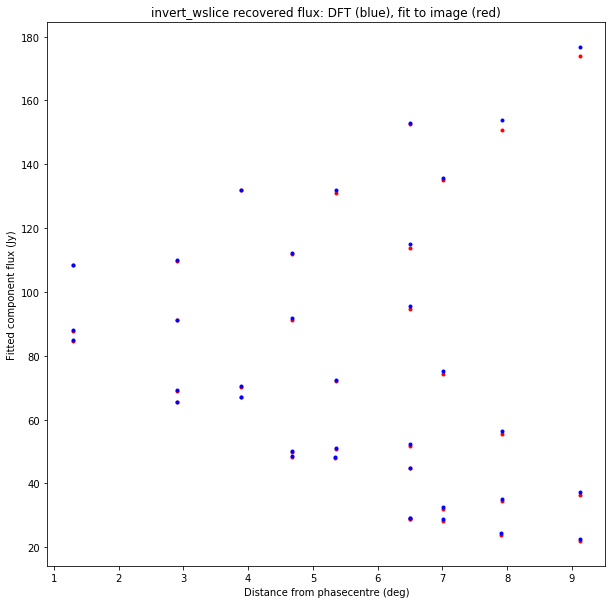

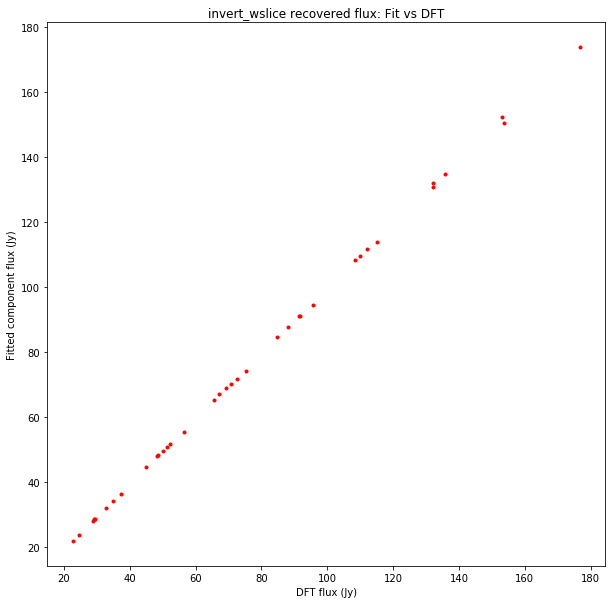

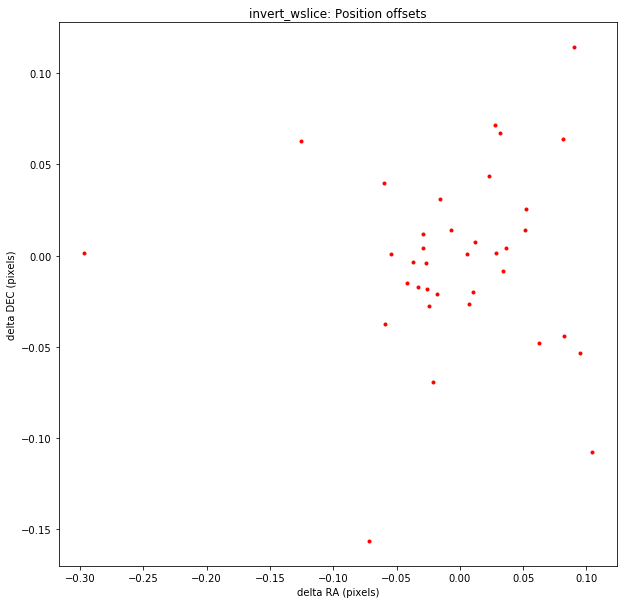

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_facets: Inverting by image facets
invert_with_image_iterator: Inverting by image partitions
raster: predicting using 8 x 8 image partitions
raster: spacing of raster (32, 32)
raster: partition (0, 0) of (8, 8)
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)>
raster: partition (1, 0) of (8, 8)
shift_vis_from_image: shifting phasecentre from vis phasec

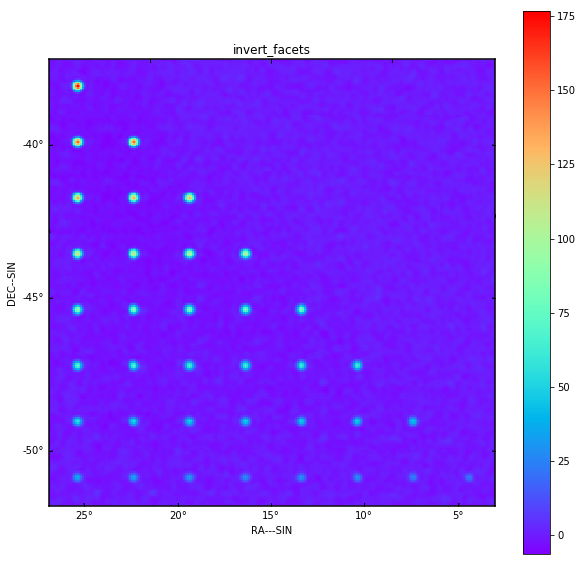

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_facets
	Data:
		shape: (1, 1, 256, 256)
		max: 176.760834311
		min: -6.3766142589
		rms: 6.58992669288
		sum: 3604.13139069
		medianabs: 1.13902069648
		median: -0.655246956317

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


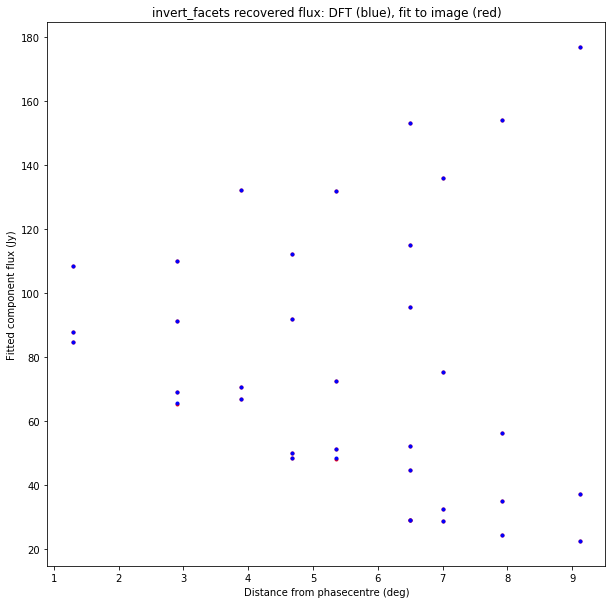

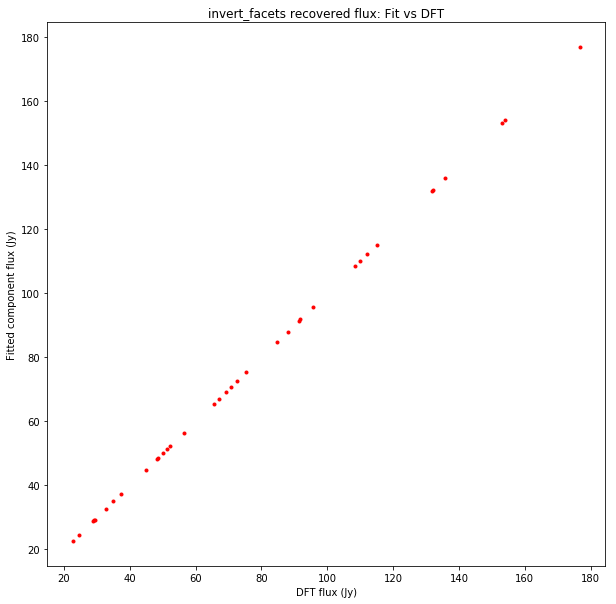

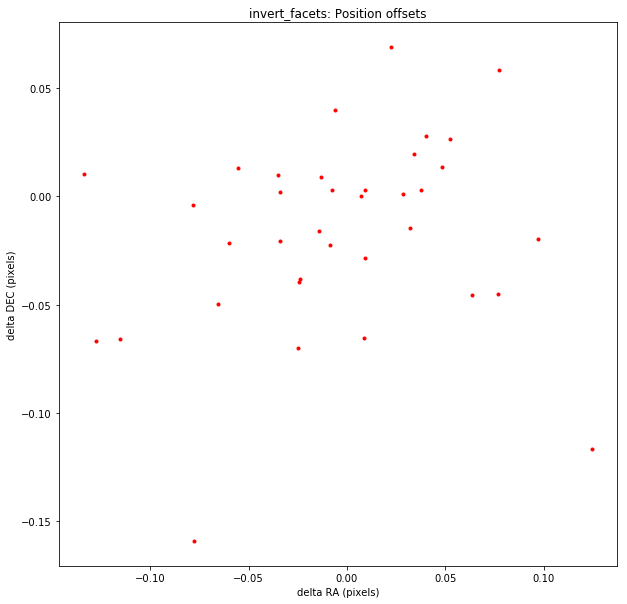

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using wprojection
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 65.536000
get_kernel_list: Recommended wstep = 0.242851
get_kernel_list: Using w projection with wstep = 10.000000
get_kernel_list: Maximum w kernel full width = 32 pixels
w_kernel_list: Maximum w = 169.6 , step is 10.0 wavelengths


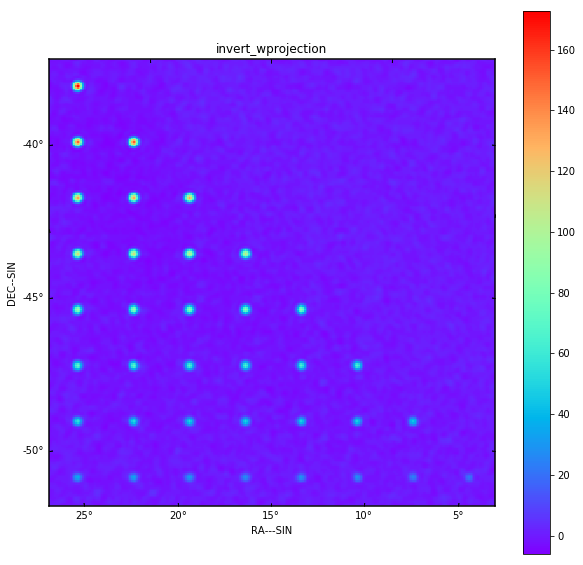

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_wprojection
	Data:
		shape: (1, 1, 256, 256)
		max: 172.852463473
		min: -6.14038583263
		rms: 6.51204796928
		sum: 3252.89723214
		medianabs: 1.13586475145
		median: -0.655363239063

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


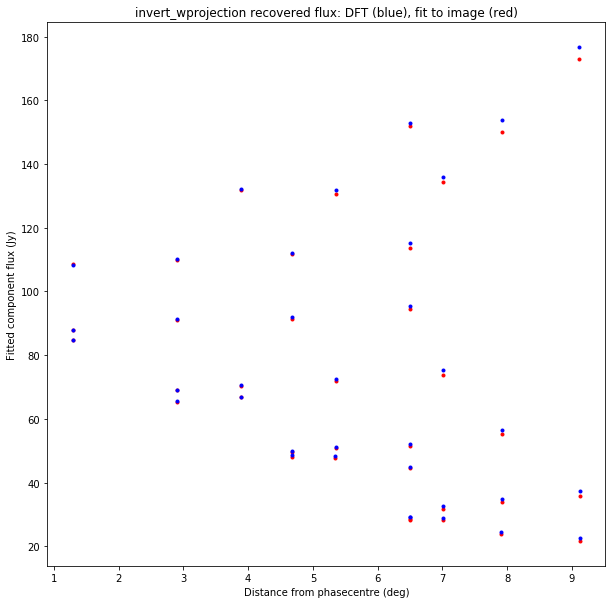

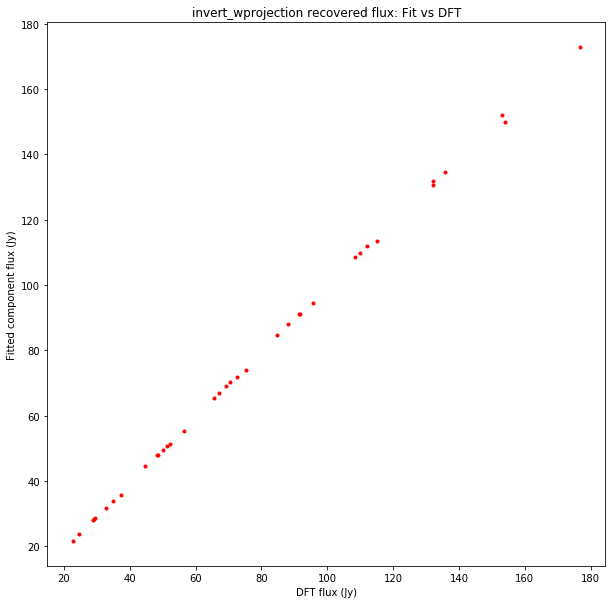

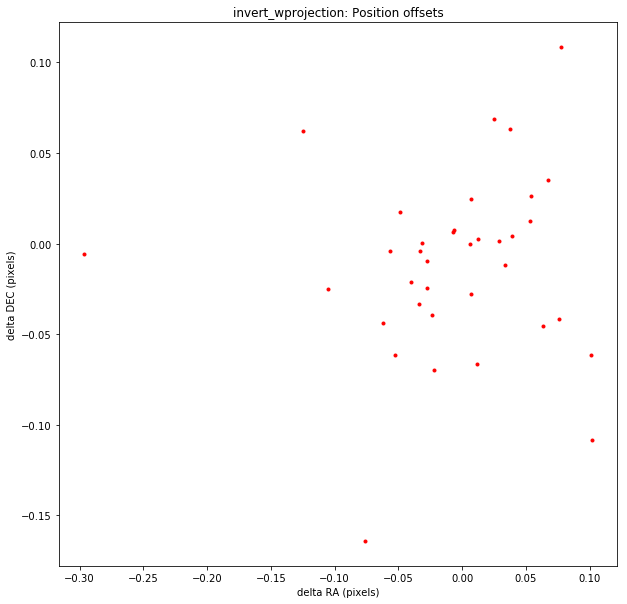

In [7]:
processors = [invert_2d, invert_timeslice, invert_wslice, invert_facets, invert_wprojection]


for processor in processors:

    targetimage = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, npol=1, nchan=1)
    targetimage, sumwt = processor(vt, targetimage, timeslice='auto', padding=2, oversampling=4,
                                  image_partitions=8, wstep=10.0, wslice=10.0)

    targetimage.data /= sumwt
    
    show_image(targetimage)
    plt.title(processor.__name__)
    plt.show()
    
    print("Dirty Image %s" % 
          qa_image(targetimage, context="imaging-fits notebook, using processor %s" %(processor.__name__)))
    
    export_image_to_fits(targetimage, 'imaging-fits_dirty_%s.fits' %(processor.__name__))

    comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5)
    plt.clf()
    for comp in comps:
        distance = comp.direction.separation(model.phasecentre)
        plt.plot(distance.deg, comp.flux[0,0], '.', color='r') 
        plt.plot(distance.deg, sum_visibility(vt, comp.direction)[0], '.', color='b')
    plt.xlabel('Distance from phasecentre (deg)')
    plt.ylabel('Fitted component flux (Jy)')
    plt.title("%s recovered flux: DFT (blue), fit to image (red)" % (processor.__name__))
    plt.show()
    plt.clf()

    for comp in comps:
        plt.plot(sum_visibility(vt, comp.direction)[0], comp.flux[0,0], '.', color='r')
    plt.ylabel('Fitted component flux (Jy)')
    plt.xlabel('DFT flux (Jy)')
    plt.title("%s recovered flux: Fit vs DFT" % (processor.__name__))
    plt.show()

    checkpositions = True
    if checkpositions:
        plt.clf()
        for i in range(len(comps)):
            ocomp = find_nearest_component(comps[i].direction, original_comps)
            plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/targetimage.wcs.wcs.cdelt[0], 
                     (comps[i].direction.dec.value - ocomp.direction.dec.value)/targetimage.wcs.wcs.cdelt[1], 
                     '.', color='r')  

        plt.xlabel('delta RA (pixels)')
        plt.ylabel('delta DEC (pixels)')
        plt.title("%s: Position offsets" % (processor.__name__))
        plt.show()